**Goal**: Analyze the competitor methods

# Competitors

In [2]:
import project_path
from rdlib import *  # this imports the base libraries

## QSmell

In [3]:
PATH_ORIGINAL_PROGRAMS = "../data/datasets/qsmell_benchmark/original_programs"
PATH_REDUCED_PROGRAMS = "../data/datasets/qsmell_benchmark/reduced_programs"

PAPER_DIR = '../data/paper_images'

In [51]:
from typing import List, Tuple, Dict, Any
import os
import pandas as pd


def get_number_of_LOC(folder: str, file_extension: str = ".py") -> Dict[str, int]:
    """Compute the number of LoC for each file in the folder.
    
    Note that it focuses only on files with the given extension (default: py).
    It returns a dictionary with the file name as key and the number of LoC 
    as value.
    """
    all_files = os.listdir(folder)
    all_files = [f for f in all_files if f.endswith(file_extension)]
    all_files_path = [os.path.join(folder, f) for f in all_files]
    all_contents = [open(f).read() for f in all_files_path]
    number_of_lines = [len(c.splitlines()) for c in all_contents]
    return {f: n for f, n in zip(all_files, number_of_lines)}

original_programs = get_number_of_LOC(PATH_ORIGINAL_PROGRAMS)
reduced_programs = get_number_of_LOC(PATH_REDUCED_PROGRAMS)
# remove the "wrapper_" from the keys of the reduced programs
reduced_programs = {
    k.replace("wrapper_", ""): v for k, v in reduced_programs.items()}

df_original = pd.DataFrame.from_dict(original_programs, orient="index", columns=["LOC"])
df_reduced = pd.DataFrame.from_dict(reduced_programs, orient="index", columns=["LOC"])
# merge the two dataframes
df = df_original.merge(df_reduced, left_index=True, right_index=True, suffixes=("_original", "_reduced"))

# reduction percentage
df['reduction_percentage'] = (df['LOC_reduced']) / df['LOC_original'] * 100
avg_reduction_percentage = df['reduction_percentage'].mean()
print("\\newcommand{\\avgReductionQsmellDynamic}{" + f"{avg_reduction_percentage:.1f}" + "\\%}")
df



\newcommand{\avgReductionQsmellDynamic}{17.0\%}


,LOC_original,LOC_reduced,reduction_percentage
phase_estimation.py,268,61,22.761194
hhl.py,548,50,9.124088
vqc.py,199,81,40.703518
qsvc.py,84,52,61.904762
vqd.py,798,71,8.897243
ipe.py,228,61,26.754386
qeom.py,598,62,10.367893
mlae.py,668,87,13.023952
qgan.py,489,67,13.701431
ae.py,674,89,13.204748


## QSmell Analysis on Our Data
Using the original code.

In [4]:
PATH_QSMELL_RESULTS = "../data/datasets/exp_v08/qsmell"
all_csv_files = [
    os.path.join(PATH_QSMELL_RESULTS, f)
    for f in os.listdir(PATH_QSMELL_RESULTS)
    if f.endswith(".csv")
]
df_qsmell = pd.concat([pd.read_csv(f) for f in all_csv_files])
# convert all errors to value 1000
df_qsmell.loc[df_qsmell["value"] == "error", "value"] = -1
# alarm when the value is greater than 0 and it is an integer
# convert the value to integer
df_qsmell["value"] = df_qsmell["value"].astype(int)
df_qsmell["alarm"] = (df_qsmell["value"] > 0)
# convert alarm column
# False > no smell
# True > smell warning
df_qsmell["alarm_msg"] = df_qsmell["alarm"].apply(
    lambda x: "no smell" if not x else "smell warning")
df_qsmell.head()

,filename,metric,value,alarm,alarm_msg
0,qiskit_runner_a05ff0.py,LPQ,0,False,no smell
1,01_operator_flow_87f6ae.py,LPQ,0,False,no smell
2,graders_f3ed23.py,LPQ,0,False,no smell
3,challenge4_circuitdecomposition_6c33bd.py,LPQ,0,False,no smell
4,run_circuit_3a72ed.py,LPQ,0,False,no smell


In [5]:
# filer for filename: cx_73cde7
df_qsmell[df_qsmell["filename"] == "cx_73cde7.py"]

,filename,metric,value,alarm,alarm_msg
5726,cx_73cde7.py,LPQ,-1,False,no smell
5726,cx_73cde7.py,NC,-1,False,no smell


\newcommand{\warningQSmellStaticNC}{29.3\%}
\newcommand{\warningQSmellStaticLPQ}{9.2\%}
\newcommand{\totalQSmellStaticNC}{2218}
\newcommand{\totalQSmellStaticLPQ}{698}


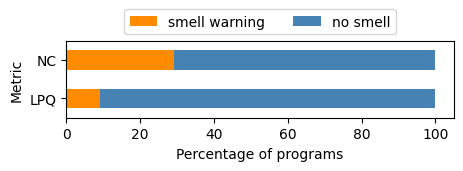

In [6]:
cross_tab_prop = pd.crosstab(
    index=df_qsmell['metric'],
    columns=df_qsmell['alarm_msg'],
    normalize="index")

# make sure that the odere is "smell warning", "no smell"
cross_tab_prop = cross_tab_prop[["smell warning", "no smell"]]
# multiply by 100 to get the percentage
cross_tab_prop = cross_tab_prop * 100

fig, ax = plt.subplots(figsize=(5, 1))
cross_tab_prop.plot(
    kind='barh', 
    stacked=True, 
    # use colors darkorange and dodgerblue
    color=["darkorange", "steelblue"],
    ax=ax
)

# put legend outside on top in the center
ax.legend(bbox_to_anchor=(0.5, 1.5), loc='upper center', ncol=2)
ax.set_xlabel("Percentage of programs")
ax.set_ylabel("Metric")
fig.savefig(
    os.path.join(PAPER_DIR, "qsmell_metrics.pdf"), 
    bbox_inches="tight")
alarm_nc = cross_tab_prop["smell warning"].loc["NC"]
print(f"\\newcommand{{\\warningQSmellStaticNC}}{{{alarm_nc:.1f}\\%}}")
alarm_lpq = cross_tab_prop["smell warning"].loc["LPQ"]
print(f"\\newcommand{{\\warningQSmellStaticLPQ}}{{{alarm_lpq:.1f}\\%}}")
total_nc_warnings = df_qsmell[df_qsmell["metric"] == "NC"]["alarm"].sum()
print(f"\\newcommand{{\\totalQSmellStaticNC}}{{{total_nc_warnings}}}")
total_lpq_warnings = df_qsmell[df_qsmell["metric"] == "LPQ"]["alarm"].sum()
print(f"\\newcommand{{\\totalQSmellStaticLPQ}}{{{total_lpq_warnings}}}")

## Inspection
Sample and inspect some smell warnings.

In [7]:
SAMPLE_SIZE = 10
SEED = 42
PROGRAM_FOLDER = "data/datasets/exp_v08/files_selected/"

# print inspection size
print(f"\\newcommand{{\\inspectionSizeQSmellStatic}}{{{SAMPLE_SIZE}}}")

for metric in ['NC', 'LPQ']:
    print("-" * 80)
    print(metric)
    df_metric = df_qsmell[df_qsmell['metric'] == metric]
    df_metric_alarm = df_metric[df_metric['alarm'] == True]
    df_sample = df_metric_alarm.sample(n=SAMPLE_SIZE, random_state=SEED)
    for i, row in df_sample.iterrows():
        filepath = os.path.join(PROGRAM_FOLDER, row['filename'])
        print(f"! code --goto {filepath}:0")

\newcommand{\inspectionSizeQSmellStatic}{10}
--------------------------------------------------------------------------------
NC
! code --goto data/datasets/exp_v08/files_selected/test_backend_qx_27fa47.py:0
! code --goto data/datasets/exp_v08/files_selected/2_c_not_n_qubits_a214e2.py:0
! code --goto data/datasets/exp_v08/files_selected/random_number_1d3eca.py:0
! code --goto data/datasets/exp_v08/files_selected/simulate_iterative_unitary_7cea96.py:0
! code --goto data/datasets/exp_v08/files_selected/bell_ineq_b3e25d.py:0
! code --goto data/datasets/exp_v08/files_selected/demo_e51c95.py:0
! code --goto data/datasets/exp_v08/files_selected/function_fc4c5a.py:0
! code --goto data/datasets/exp_v08/files_selected/randomized_benchmarking_442f91.py:0
! code --goto data/datasets/exp_v08/files_selected/gate_funcs_0ee543.py:0
! code --goto data/datasets/exp_v08/files_selected/week3_a0b2e5.py:0
--------------------------------------------------------------------------------
LPQ
! code --goto dat